In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [202]:
class Reader:
    def __init__(self, file, cols, data_cols):
        lexems = [set() for i in range(len(cols))]
        f = open(file, 'r')
        for line in f:
            tokens = line.split(',')
            for i, c in enumerate(cols):
                if tokens[i] not in lexems[i]:
                    lexems[i].add(tokens[i])
        self.list_lexems = [sorted(list(l)) for l in lexems]
        self.dict_lexems = [{x:i for i,x in enumerate(l)} for l in self.list_lexems]
        self.dims = [len(d) for d in self.list_lexems]
        self.muls = [1 for i in range(len(self.dims))]
        for i in range(len(self.dims)-2,-1,-1):
            self.muls[i] = self.muls[i+1]*self.dims[i+1]
        self.count = np.prod(self.dims)
        self.data = [[] for i in range(self.count)]
        f.seek(0)
        for line in f:
            tokens = line.split(',')
            dat = []
            lexems = []
            for c in cols:
                lexems.append(tokens[c])
            for c in data_cols:
                if tokens[c].lower() == "true" or tokens[c].lower() == "false":
                    dat.append(int(tokens[c].lower() == "true"))
                else:
                    dat.append(float(tokens[c]))
            self.append(lexems, dat)
        f.close()
    def append(self, lexems, dat):
        index = 0
        for i, l in enumerate(lexems):
            local_index = self.dict_lexems[i][l]
            index += self.muls[i] * local_index
        self.data[index].append(dat)
    def get(self, tuple_index):
        index = 0
        for i in range(len(tuple_index)):
            index += self.muls[i] * tuple_index[i]
        return np.array(self.data[index])
    def reduce(self, index):
        means = np.zeros(tuple(self.dims))
        stds = np.zeros(tuple(self.dims))
        for i in range(self.count):
            index = [0 for j in range(len(self.dims))]
            cur = i
            for j in range(len(self.dims)):
                index[j] = cur // self.muls[j]
                cur %= self.muls[j]
            means[tuple(index)] = np.mean(self.data[i])
            stds[tuple(index)] = np.std(self.data[i])
        return means, stds
    
def graph_dual_reducer_hardness(reader, alpha_index):
    plt.rcParams["figure.autolayout"] = True
    figs, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
    hardness = [1, 3, 5, 7, 9, 11, 13]
    for i, ax in enumerate(axs):
        Y1 = np.zeros((2, len(hardness)))
        Y2 = np.zeros((2, len(hardness)))
        names = ["ssds", "tpch"]
        y_names = ["Recall rate (%)", "Approximation error (%)", "Time (s)"]
        for s in range(2):
            for h in range(len(hardness)):
                dat = reader.get([s, alpha_index, h])
                if i == 0:
                    new_dat = np.sum(dat, axis=0)
                    if new_dat[0] > 0:
                        Y1[s, h] = new_dat[1] / new_dat[0] * 100
                        Y2[s, h] = new_dat[2] / new_dat[0] * 100
                elif i == 1:
                    ap1 = []
                    ap2 = []
                    for tup in dat:
                        if tup[1] > 0:
                            ap1.append(abs((tup[4]-tup[3])/tup[3])*100)
                        if tup[2] > 0:
                            ap1.append(abs((tup[5]-tup[3])/tup[3])*100)
                    if len(ap1) == 0:
                        Y1[s, h] = 0
                    else:
                        Y1[s, h] = np.mean(ap1)
                    if len(ap2) == 0:
                        Y2[s, h] = 0
                    else:
                        Y2[s, h] = np.mean(ap2)
                else:
                    ap1 = []
                    ap2 = []
                    for tup in dat:
                        ap1.append(tup[-2])
                        ap2.append(tup[-1])
                    Y1[s, h] = np.mean(ap1) / 1000
                    Y2[s, h] = np.mean(ap2) / 1000
            ax.plot(hardness, Y1[s], label="Our on {}".format(names[s]), alpha=0.3, lw=8)
            ax.plot(hardness, Y2[s], label="Gurobi on {}".format(names[s]), lw=2)
            ax.set_xlabel("Hardness")
            ax.set_ylabel(y_names[i])
            if i == 1:
                ax.set_ylim(0, 2)
            ax.legend()
    plt.suptitle("Adversity: " + str(reader.list_lexems[1][alpha_index]))

In [203]:
reader = Reader('dual_reducer_hardness.csv', [0,1,2], [3,4,5,6,7,8,9,10,11])

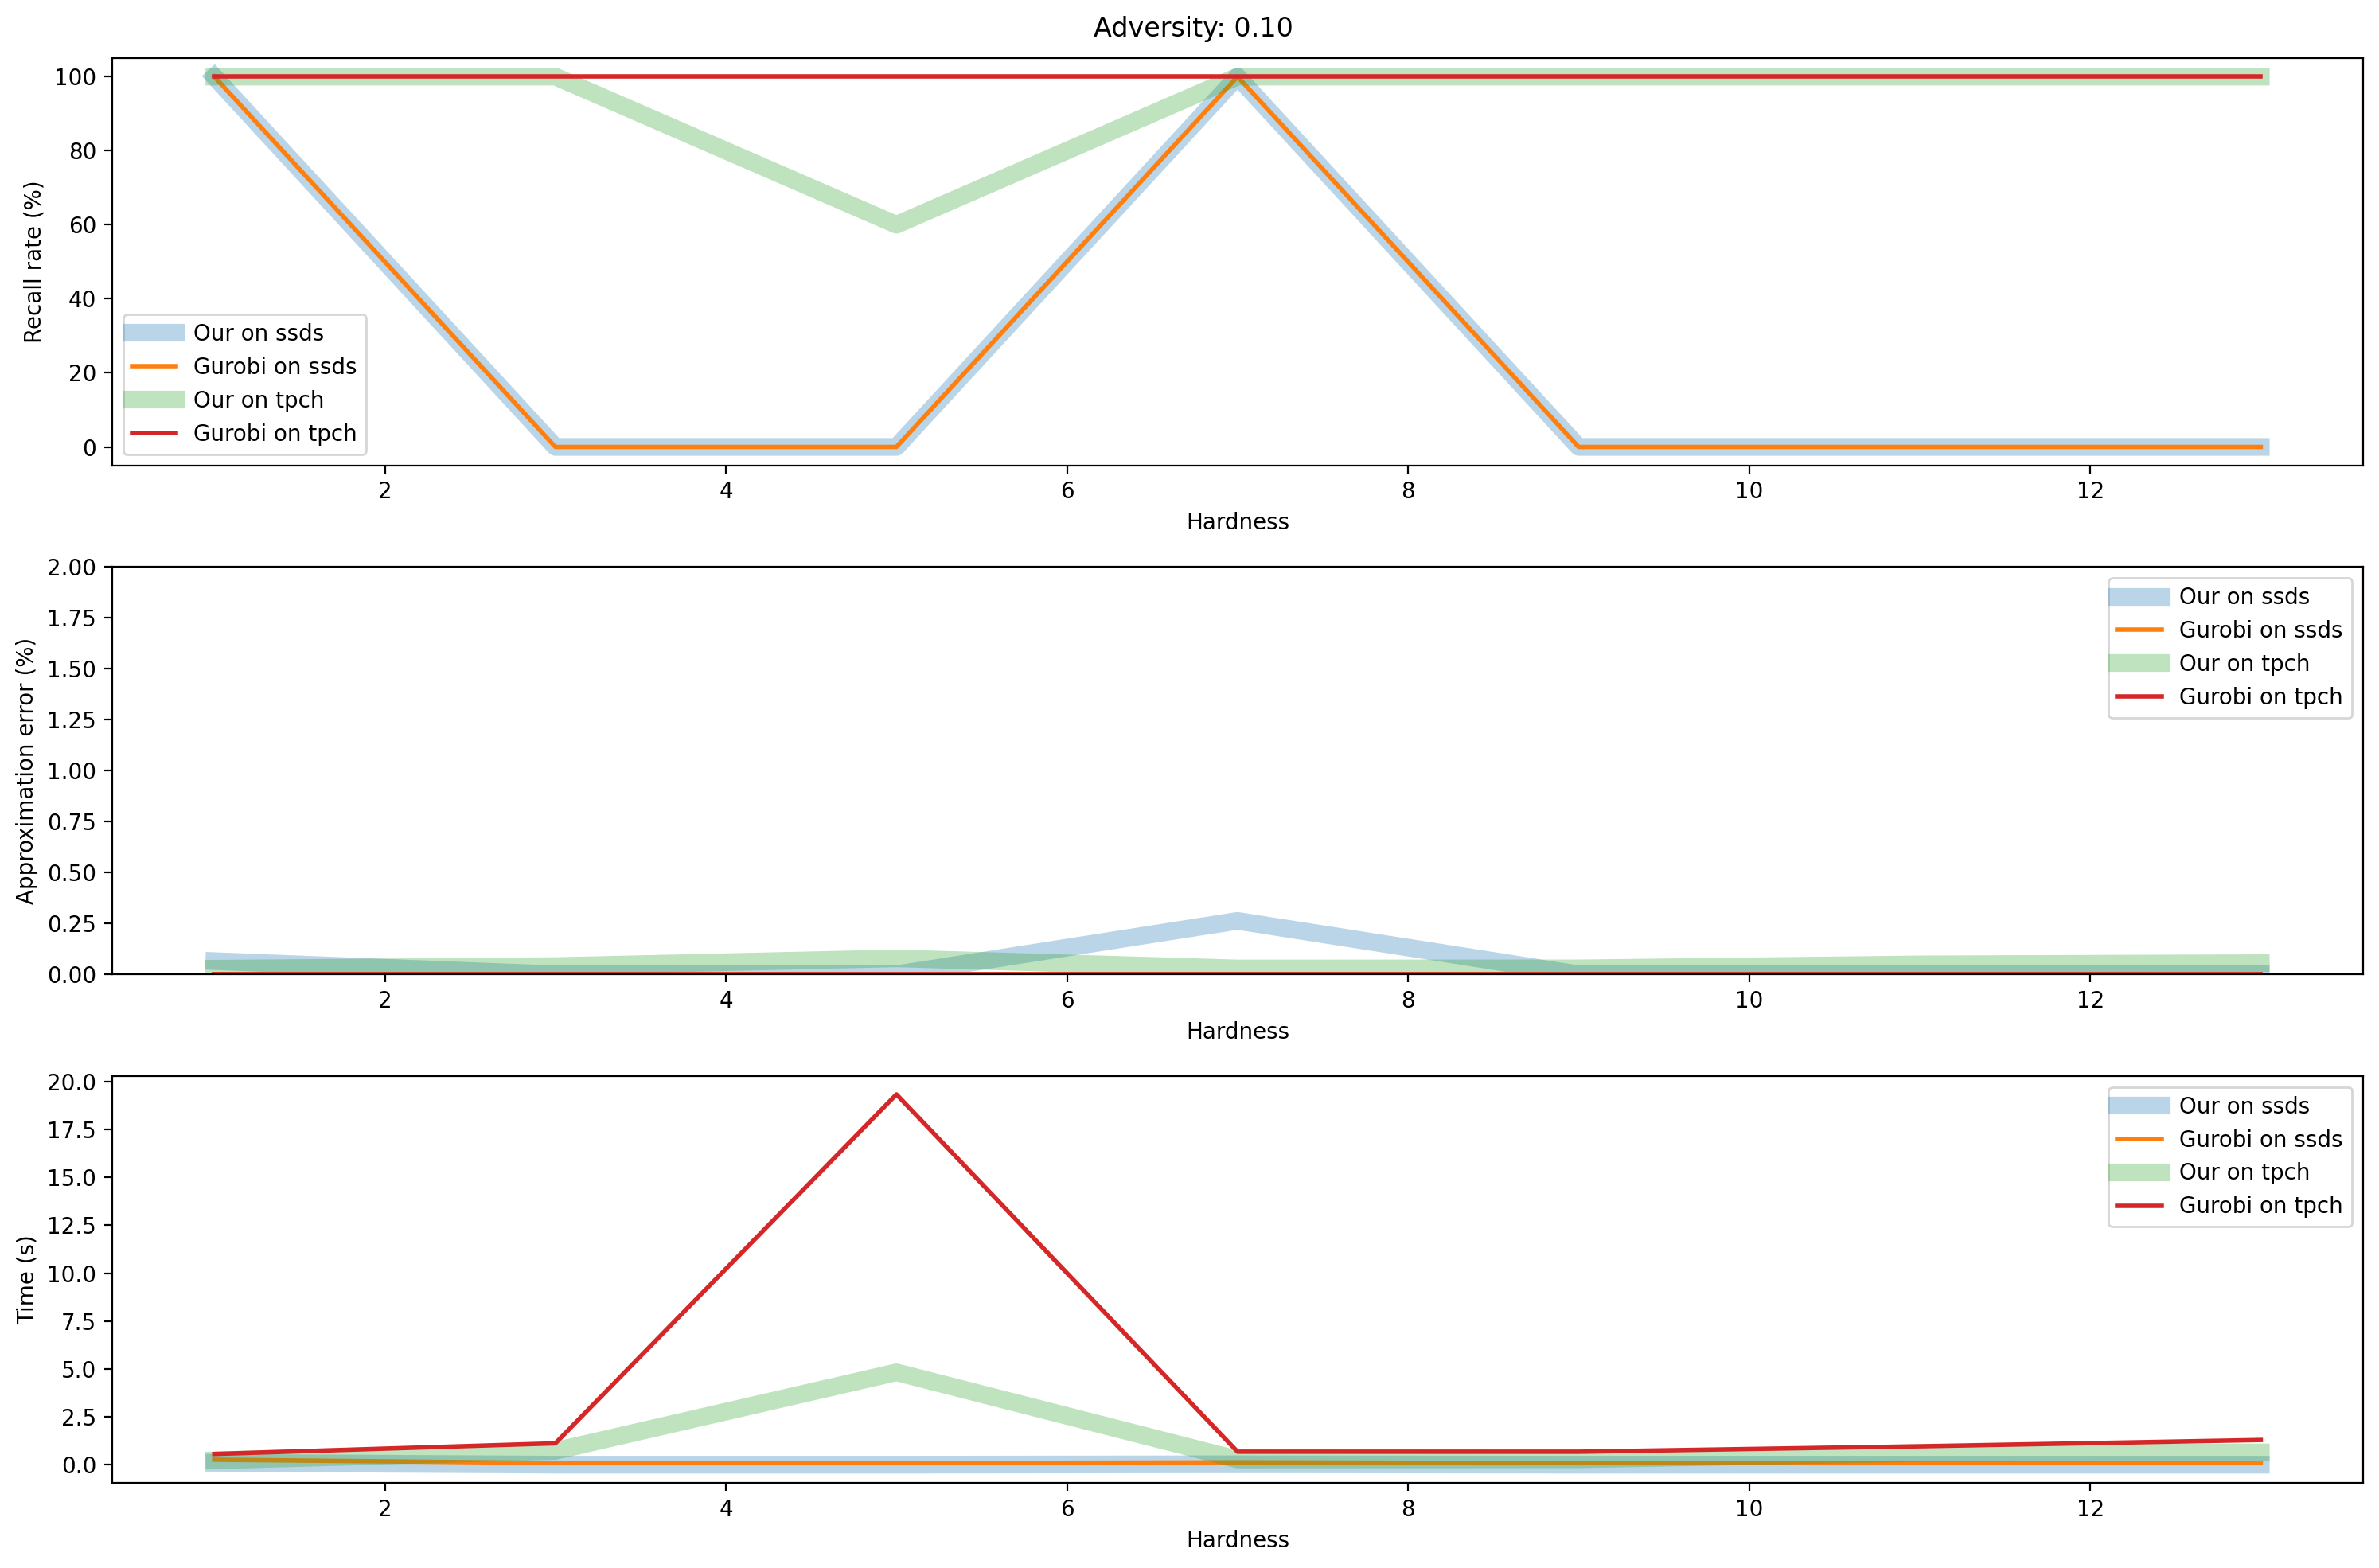

In [204]:
graph_dual_reducer_hardness(reader, 0)

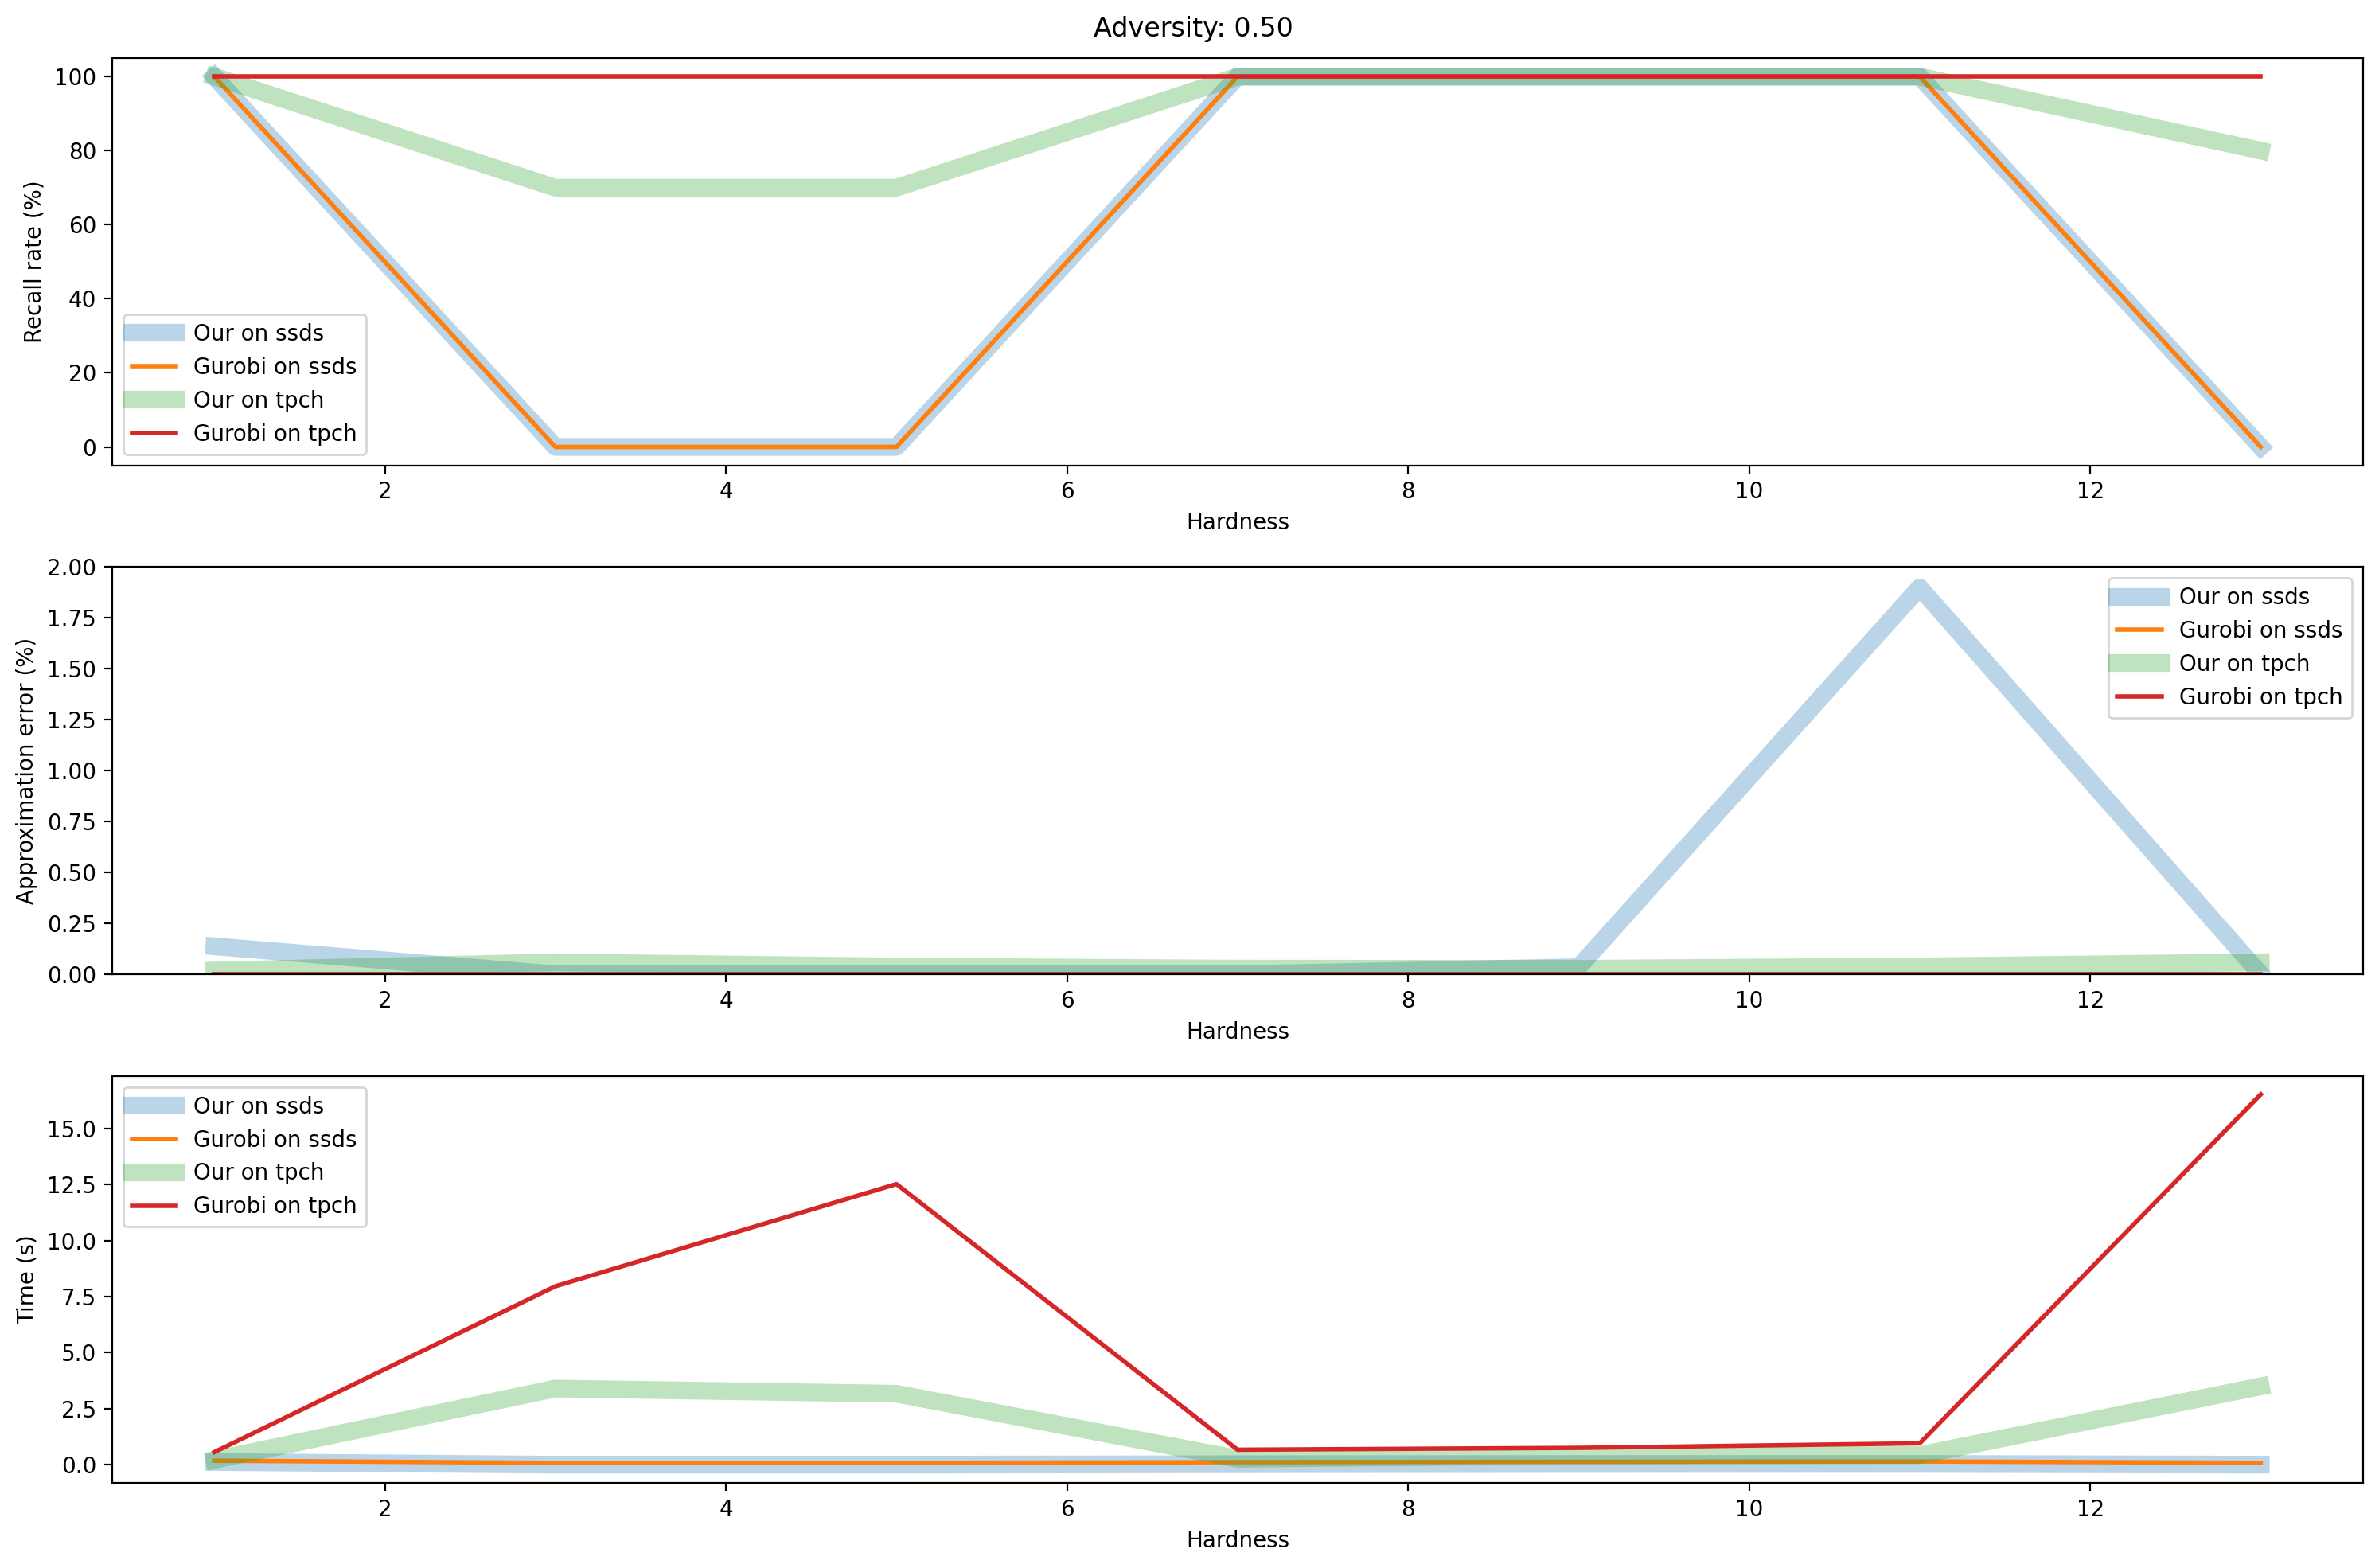

In [205]:
graph_dual_reducer_hardness(reader, 1)

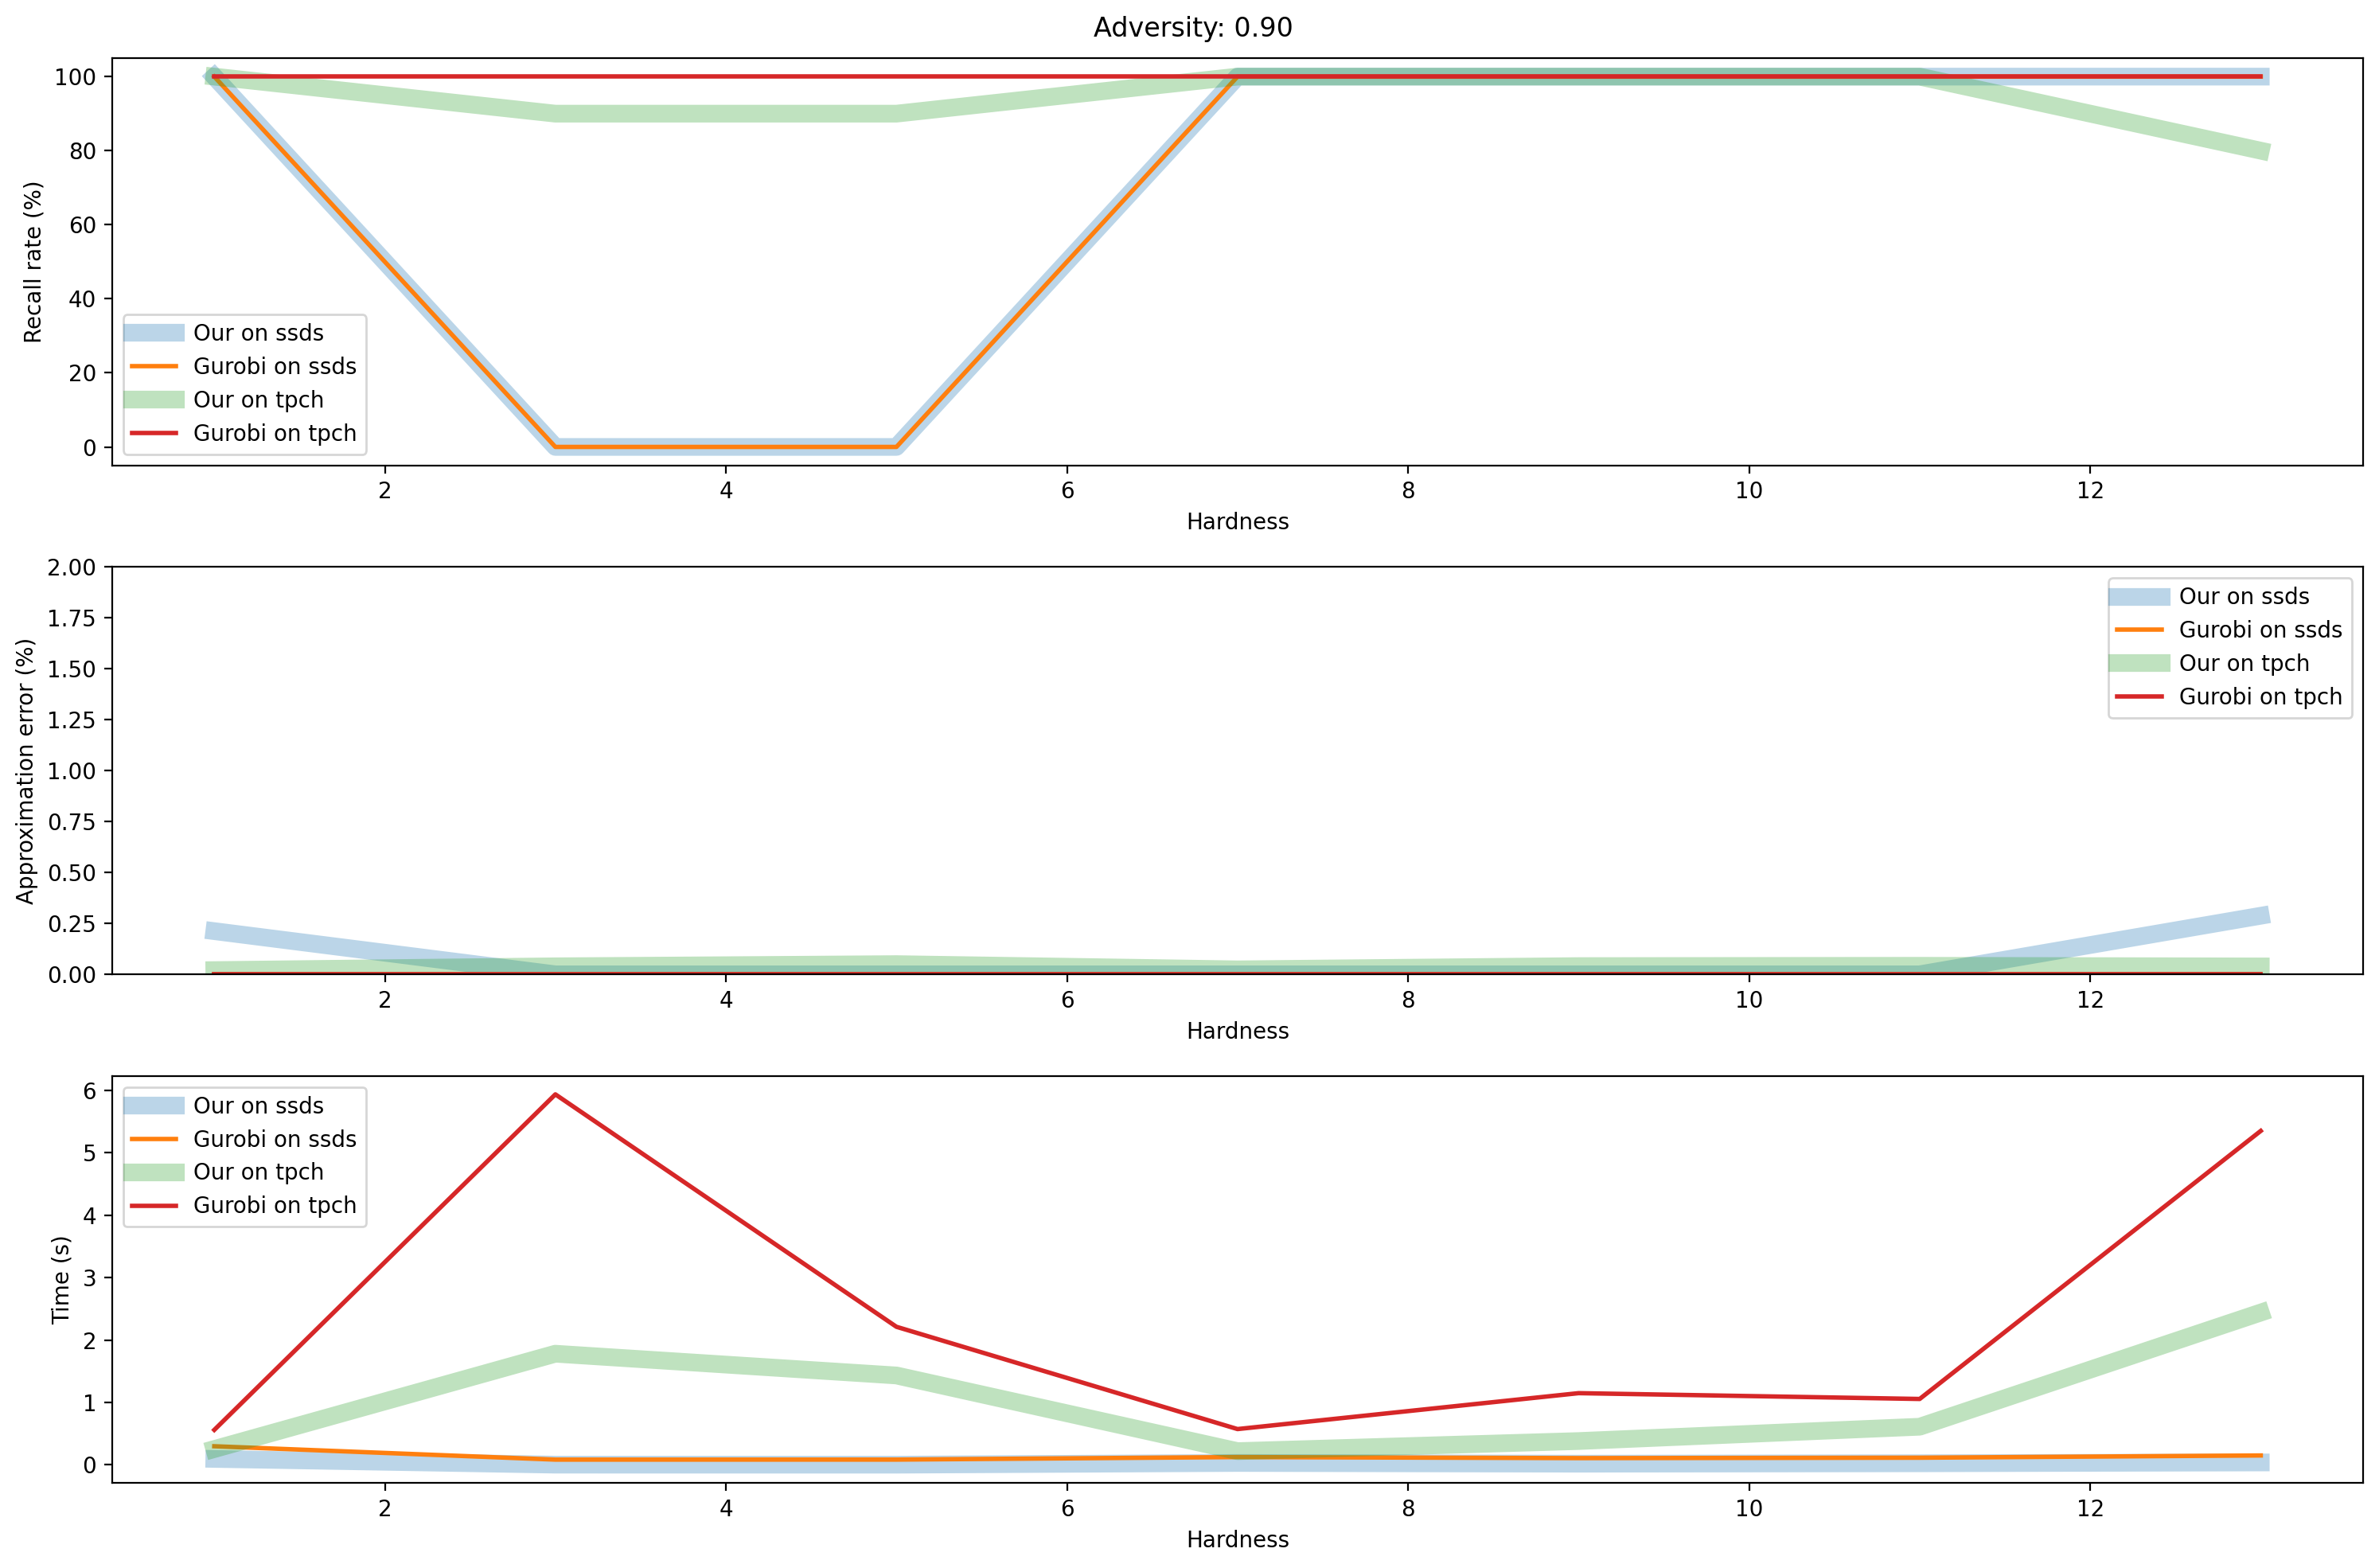

In [206]:
graph_dual_reducer_hardness(reader, 2)